# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [162]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

In [163]:
def columns_to_drop(df):
    """
    Identify and return column names with missing values greater than or equal to 40%.

    INPUT:
    - df (DataFrame): The DataFrame to evaluate.

    OUTPUT:
    - List of column names with missing values >= 40%.
    """
    # Calculate the percentage of missing values for each column
    missing_percentage = df.isnull().mean() * 100

    # Filter columns where the percentage of missing values is >= 40%
    columns_to_drop = missing_percentage[missing_percentage >= 40].index.tolist()

    return columns_to_drop

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [164]:
# Load in the data (RUN THIS CELL ON JUPYTER NOTEBOOK)
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [165]:
# Load in the data (RUN THIS CELL ON LOCAL VSCODE DESKTOP)
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

# Take a subset of azdias, and we'll load all subsets of data and combine them after data cleaning
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', nrows = 89000)

/var/folders/p2/k2r08vgd17bc1xcc1zkn7_c40000gn/T/ipykernel_4326/1474008397.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')
/var/folders/p2/k2r08vgd17bc1xcc1zkn7_c40000gn/T/ipykernel_4326/1474008397.py:5: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', nrows = 89000)


In [166]:
print(azdias.shape)
display(azdias.head())

(89000, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [167]:
print(customers.shape)
display(customers.head())

(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [168]:
df_azdias = azdias.copy()
df_customers = customers.copy()

# Display the columns in Customer dataset that are not in Population dataset
extra_cols = print(set(df_customers.columns) - set(df_azdias.columns))
extra_cols

{'CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'}


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Data Pre-processing & Exploratory Data Analysis (EDA)

In [169]:
# Drop the three additional features in the CUSTOMERS dataset before cleaning data
df_customers.drop(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)

In [170]:
# Display basic information about the datasets
print(df_azdias.info())
print(df_customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89000 entries, 0 to 88999
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 248.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 535.2+ MB
None


In [171]:
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

attributes_values = attributes_values[attributes_values.columns[1:]]

In [172]:
# Forward fill the NaN values with the respective attribute names
attributes_values['Attribute'].fillna(method='ffill', inplace=True)

# Drop the 'Description' column
attributes_values = attributes_values.drop(['Description'], axis=1)

In [173]:
# Function to split comma-separated values into separate rows
def split_values(row):
    values = str(row['Value']).split(',')
    # Create a new DataFrame for the split values with repeated other column values
    return pd.DataFrame({
        'Attribute': [row['Attribute']] * len(values),
        'Value': [value.strip() for value in values], 
        'Meaning': [row['Meaning']] * len(values)
    })

# Apply the function and concatenate the results
attributes_values_splited = pd.concat([split_values(row) for index, row in attributes_values.iterrows()], ignore_index=True)


In [174]:
# Filter out rows with 'unknown' meaning
unknown = attributes_values_splited[
    attributes_values_splited['Meaning'].isin(['unknown', 'unknown / no main age detectable'])
    ]

In [175]:
def replace_with_nan(df, unknown_df = unknown):
    """
    Replaces specified values in df with NaN based on the conditions provided in unknown_df.

    Parameters:
        df (pd.DataFrame): The main DataFrame where replacements need to be made.
        unknown_df (pd.DataFrame): DataFrame containing the conditions for replacement.

    Returns:
        pd.DataFrame: The DataFrame with the specified values replaced by NaN.
    """
    for _, row in unknown_df.iterrows():
        attribute = row['Attribute']
        try:
            values = [int(v) for v in row['Value'].split(',')]  # Handles values that are integers separated by commas
        except ValueError:
            values = [row['Value']]  # Handles single value entries
        for value in values:
            if attribute in df.columns:
                df.loc[df[attribute] == value, attribute] = np.nan
    return df

In [176]:
# Define a threshold
threshold = 40

# Calculate the percentage of missing values for each column
missing_percentage_azdias = df_azdias.isnull().mean() * 100
missing_percentage_customers = df_customers.isnull().mean() * 100

# Identify columns in the general population dataset with missing values above the threshold
high_missing_azdias = missing_percentage_azdias[missing_percentage_azdias > threshold]
print("Columns with more than 40% missing values in AZDIAS dataset:")
print(high_missing_azdias)

# Identify columns in the customer dataset with missing values above the threshold
high_missing_customers = missing_percentage_customers[missing_percentage_customers > threshold]
print("Columns with more than 40% missing values in CUSTOMERS dataset:")
print(high_missing_customers)

Columns with more than 40% missing values in AZDIAS dataset:
ALTER_KIND1     91.024719
ALTER_KIND2     96.793258
ALTER_KIND3     99.313483
ALTER_KIND4     99.875281
EXTSEL992       73.569663
KK_KUNDENTYP    66.117978
dtype: float64
Columns with more than 40% missing values in CUSTOMERS dataset:
ALTER_KIND1     93.860748
ALTER_KIND2     97.338927
ALTER_KIND3     99.334732
ALTER_KIND4     99.876860
EXTSEL992       44.498883
KK_KUNDENTYP    58.406382
dtype: float64


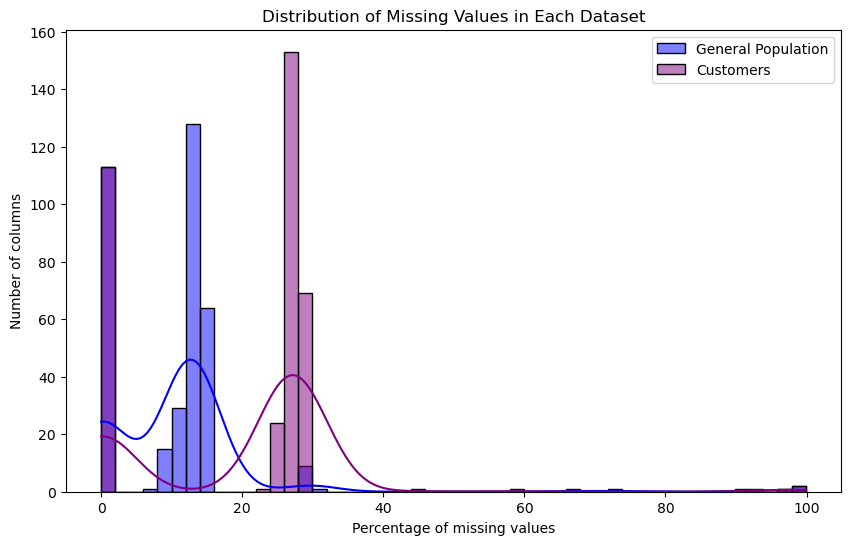

In [177]:
# Calculate the percentage of missing values in each column
azdias_missing = df_azdias.isnull().mean() * 100
customers_missing = df_customers.isnull().mean() * 100

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(azdias_missing, bins=50, kde=True, color='blue', label='General Population')
sns.histplot(customers_missing, bins=50, kde=True, color='purple', label='Customers')
plt.xlabel('Percentage of missing values')
plt.ylabel('Number of columns')
plt.title('Distribution of Missing Values in Each Dataset')
plt.legend()
plt.show()

Comments: 

- Both datasets have a high concentration of columns with low percentages of missing values, indicating a positive pattern that most of the data is complete. 

- The general population data exhibits distinct peaks of missing values clustered around 0-15%, while the customer data shows a different pattern, with significant peaks at both 0-10% and around 30%. 

- There are columns in the two datasets with extremely high missing values (close to 100%). These columns are worth investigating and possibly we could remove those columns with high proportion of NaN values. 

In [178]:
# Remove columns with missing values >= 40%
df_azdias = replace_with_nan(df_azdias)
df_customers = replace_with_nan(df_customers)

In [179]:
# Replace specified unknown values with NaN
df_azdias.drop(labels=columns_to_drop(df_azdias), axis=1, inplace=True)
df_customers.drop(labels=columns_to_drop(df_customers), axis=1, inplace=True)

In [180]:
# Replace specific strings with NaN
df_azdias['CAMEO_DEUG_2015'] = df_azdias['CAMEO_DEUG_2015'].replace('X', np.nan)
df_azdias['CAMEO_INTL_2015'] = df_azdias['CAMEO_INTL_2015'].replace('XX', np.nan)

df_customers['CAMEO_DEUG_2015'] = df_customers['CAMEO_DEUG_2015'].replace('X', np.nan)
df_customers['CAMEO_INTL_2015'] = df_customers['CAMEO_INTL_2015'].replace('XX', np.nan)

In [181]:
# Convert 'CAMEO_DEUG_2015' and 'CAMEO_INTL_2015' to float
df_azdias['CAMEO_DEUG_2015'] = df_azdias['CAMEO_DEUG_2015'].astype(float)
df_azdias['CAMEO_INTL_2015'] = df_azdias['CAMEO_INTL_2015'].astype(float)

df_customers['CAMEO_DEUG_2015'] = df_customers['CAMEO_DEUG_2015'].astype(float)
df_customers['CAMEO_INTL_2015'] = df_customers['CAMEO_INTL_2015'].astype(float)

In [182]:
# Change the data type of EINGEFUEGT_AM to datetime and extract year and month
df_azdias["EINGEFUEGT_AM"] = pd.to_datetime(df_azdias["EINGEFUEGT_AM"], errors='coerce')
df_azdias['EINGEFUEGT_YEAR'] = df_azdias['EINGEFUEGT_AM'].dt.year
df_azdias['EINGEFUEGT_MONTH'] = df_azdias['EINGEFUEGT_AM'].dt.month
df_azdias.drop(columns=['EINGEFUEGT_AM'], inplace=True)

df_customers["EINGEFUEGT_AM"] = pd.to_datetime(df_customers["EINGEFUEGT_AM"], errors='coerce')
df_customers['EINGEFUEGT_YEAR'] = df_customers['EINGEFUEGT_AM'].dt.year
df_customers['EINGEFUEGT_MONTH'] = df_customers['EINGEFUEGT_AM'].dt.month
df_customers.drop(columns=['EINGEFUEGT_AM'], inplace=True)

In [183]:
# Identify and drop categorical columns with >=15 unique categories
categorical_cols_azdias = df_azdias.select_dtypes(include=['object', 'category']).columns
cat_cols_with_many_cats_azdias = [col for col in categorical_cols_azdias if df_azdias[col].nunique() >= 15]
print(f'Columns in the population dataset with >= 15 unique categories: {cat_cols_with_many_cats_azdias}')
df_azdias = df_azdias.drop(columns=cat_cols_with_many_cats_azdias)

categorical_cols_customers = df_customers.select_dtypes(include=['object', 'category']).columns
cat_cols_with_many_cats_customers = [col for col in categorical_cols_customers if df_customers[col].nunique() >= 15]
print(f'Columns in the customers dataset with >= 15 unique categories: {cat_cols_with_many_cats_customers}')
df_customers = df_customers.drop(columns=cat_cols_with_many_cats_customers)

Columns in the population dataset with >= 15 unique categories: ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE']
Columns in the customers dataset with >= 15 unique categories: ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE']


In [184]:
# Encode binary categorical variables
df_azdias['OST_WEST_KZ'] = df_azdias['OST_WEST_KZ'].map({'W': 0, 'O': 1})
df_customers['OST_WEST_KZ'] = df_customers['OST_WEST_KZ'].map({'W': 0, 'O': 1})

In [185]:
# Identify and drop columns with high correlations (abs >= 0.9)
corr_matrix_azdias = df_azdias.corr()
high_corr_cols = set()
high_corr_pairs = []
for i in range(len(corr_matrix_azdias.columns)):
    for j in range(i + 1, len(corr_matrix_azdias.columns)):
        if abs(corr_matrix_azdias.iloc[i, j]) >= 0.9:
            high_corr_pairs.append((corr_matrix_azdias.columns[i], corr_matrix_azdias.columns[j], corr_matrix_azdias.iloc[i, j]))
            high_corr_cols.add(corr_matrix_azdias.columns[j])
for pair in high_corr_pairs:
    print(f"High correlation ({pair[0]}, {pair[1]}): {pair[2]}")
df_azdias = df_azdias.drop(columns=high_corr_cols)


High correlation (ANZ_HAUSHALTE_AKTIV, ANZ_STATISTISCHE_HAUSHALTE): 0.9843846905732984
High correlation (CAMEO_DEUG_2015, CAMEO_INTL_2015): 0.9553603782500741
High correlation (D19_GESAMT_ANZ_12, D19_GESAMT_ANZ_24): 0.9086329158527066
High correlation (D19_GESAMT_ANZ_12, D19_VERSAND_ANZ_12): 0.9080121543442198
High correlation (D19_GESAMT_ANZ_24, D19_VERSAND_ANZ_24): 0.9210319867180353
High correlation (D19_GESAMT_ONLINE_DATUM, D19_VERSAND_DATUM): 0.913598462072908
High correlation (D19_GESAMT_ONLINE_DATUM, D19_VERSAND_ONLINE_DATUM): 0.9439027944463224
High correlation (D19_GESAMT_ONLINE_QUOTE_12, D19_VERSAND_ONLINE_QUOTE_12): 0.9158766538732331
High correlation (D19_VERSAND_ANZ_12, D19_VERSAND_ANZ_24): 0.9088641036790394
High correlation (D19_VERSAND_DATUM, D19_VERSAND_ONLINE_DATUM): 0.9575807219987037
High correlation (GEMEINDETYP, ORTSGR_KLS9): -0.9346363130309707
High correlation (KBA13_ALTERHALTER_61, KBA13_HALTER_66): 0.927792184839078
High correlation (KBA13_ANTG1, PLZ8_ANTG1): 

In [186]:
# Identify and drop columns with high correlations (abs >= 0.9)
corr_matrix_customers = df_customers.corr()
high_corr_cols = set()
high_corr_pairs = []
for i in range(len(corr_matrix_customers.columns)):
    for j in range(i + 1, len(corr_matrix_customers.columns)):
        if abs(corr_matrix_customers.iloc[i, j]) >= 0.9:
            high_corr_pairs.append((corr_matrix_customers.columns[i], corr_matrix_customers.columns[j], corr_matrix_customers.iloc[i, j]))
            high_corr_cols.add(corr_matrix_customers.columns[j])
for pair in high_corr_pairs:
    print(f"High correlation ({pair[0]}, {pair[1]}): {pair[2]}")
df_customers = df_customers.drop(columns=high_corr_cols)

High correlation (ANZ_HAUSHALTE_AKTIV, ANZ_STATISTISCHE_HAUSHALTE): 0.990112182424038
High correlation (CAMEO_DEUG_2015, CAMEO_INTL_2015): 0.9567592799180701
High correlation (CJT_TYP_1, CJT_TYP_2): 0.9291517520878818
High correlation (D19_GESAMT_ANZ_12, D19_GESAMT_ANZ_24): 0.9063696286084569
High correlation (D19_GESAMT_ANZ_12, D19_VERSAND_ANZ_12): 0.9376296937743268
High correlation (D19_GESAMT_ANZ_24, D19_VERSAND_ANZ_24): 0.9455602714101565
High correlation (D19_GESAMT_ONLINE_DATUM, D19_VERSAND_ONLINE_DATUM): 0.9438129594824207
High correlation (D19_GESAMT_ONLINE_QUOTE_12, D19_VERSAND_ONLINE_QUOTE_12): 0.917168042205449
High correlation (D19_VERSAND_ANZ_12, D19_VERSAND_ANZ_24): 0.9054436043361346
High correlation (D19_VERSAND_DATUM, D19_VERSAND_ONLINE_DATUM): 0.9028388134616675
High correlation (FINANZ_ANLEGER, FINANZ_SPARER): 0.9146499259270324
High correlation (FINANZ_SPARER, FINANZ_VORSORGER): -0.9110472783184427
High correlation (GEMEINDETYP, ORTSGR_KLS9): -0.928914615103956
Hig

In [187]:
# Fill numerical columns with the median and categorical columns with the mode
numerical_columns_azdias = df_azdias.select_dtypes(include=['number']).columns
categorical_columns_azdias = df_azdias.select_dtypes(include=['object', 'category']).columns
for column in numerical_columns_azdias:
    median_value = df_azdias[column].median()
    df_azdias[column] = df_azdias[column].fillna(median_value)
for column in categorical_columns_azdias:
    if df_azdias[column].mode().size > 0: 
        mode_value = df_azdias[column].mode().iloc[0]
        df_azdias[column] = df_azdias[column].fillna(mode_value)

In [188]:
# Fill numerical columns with the median and categorical columns with the mode
numerical_columns_customers = df_customers.select_dtypes(include=['number']).columns
categorical_columns_customers = df_customers.select_dtypes(include=['object', 'category']).columns
for column in numerical_columns_customers:
    median_value = df_customers[column].median()
    df_customers[column] = df_customers[column].fillna(median_value)
for column in categorical_columns_customers:
    if df_customers[column].mode().size > 0: 
        mode_value = df_customers[column].mode().iloc[0]
        df_customers[column] = df_customers[column].fillna(mode_value)

In [189]:
# Create dummy variables for the categorical columns
df_azdias = pd.get_dummies(df_azdias, columns=categorical_columns_azdias, drop_first=True)
df_customers = pd.get_dummies(df_customers, columns=categorical_columns_customers, drop_first=True)


In [190]:
# Remove the unnecessary columns
df_azdias = df_azdias.drop(columns='LNR')
df_customers = df_customers.drop(columns='LNR')


In [191]:
# For simplicity, we create a function to simplify the processes of data cleaning

def data_cleaning(df):
    """
    Cleans a DataFrame by applying various preprocessing steps including replacing NaN values, 
    dropping columns based on correlation, converting data types, and encoding categorical variables.

    Parameters:
    df (pd.DataFrame): The input DataFrame to be cleaned.

    Returns:
    pd.DataFrame: The cleaned DataFrame with preprocessing applied.
    """

    df = replace_with_nan(df)
    df.drop(labels=columns_to_drop(df), axis=1, inplace=True)

    # Replace specific strings with NaN
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan)
    # Convert 'CAMEO_DEUG_2015' and 'CAMEO_INTL_2015' to float
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)

    # Change the data type of EINGEFUEGT_AM to datetime and extract year and month
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"], errors='coerce')
    df['EINGEFUEGT_YEAR'] = df['EINGEFUEGT_AM'].dt.year
    df['EINGEFUEGT_MONTH'] = df['EINGEFUEGT_AM'].dt.month
    df.drop(columns=['EINGEFUEGT_AM'], inplace=True)

    # Identify and drop categorical columns with >=15 unique categories
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    cat_cols_with_many_cats = [col for col in categorical_cols if df[col].nunique() >= 15]
    df = df.drop(columns=cat_cols_with_many_cats)

    # Encode binary categorical variables
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})

    # Drop columns with high correlations (abs >= 0.9)
    corr_matrix = df.corr()
    high_corr_cols = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= 0.9:
                high_corr_cols.add(corr_matrix.columns[j])
    df = df.drop(columns=high_corr_cols)

    # Fill numerical columns with the median and categorical columns with the mode
    numerical_columns = df.select_dtypes(include=['number']).columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for column in numerical_columns:
        median_value = df[column].median()
        df[column] = df[column].fillna(median_value)
    for column in categorical_columns:
        if df[column].mode().size > 0:  # Check if mode exists
            mode_value = df[column].mode().iloc[0]
            df[column] = df[column].fillna(mode_value)

    # Create dummy variables for the categorical columns
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    df = df.drop(columns='LNR')

    return df

In [192]:
azdias_1 = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', nrows=300000)
azdias_2 = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', skiprows=range(1, 300000 + 1), nrows=300000)
azdias_3 = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', skiprows=range(1, 2 * 300000 + 1))


/var/folders/p2/k2r08vgd17bc1xcc1zkn7_c40000gn/T/ipykernel_4326/2741126134.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias_1 = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', nrows=300000)
/var/folders/p2/k2r08vgd17bc1xcc1zkn7_c40000gn/T/ipykernel_4326/2741126134.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias_2 = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', skiprows=range(1, 300000 + 1), nrows=300000)
/var/folders/p2/k2r08vgd17bc1xcc1zkn7_c40000gn/T/ipykernel_4326/2741126134.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias_3 = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', skiprows=range(1, 2 * 300000 + 1))


In [193]:
df_azdias_1 = azdias_1.copy()
df_azdias_2 = azdias_2.copy()
df_azdias_3 = azdias_3.copy()

df_azdias_1_cleaned = data_cleaning(df_azdias_1)
df_azdias_2_cleaned = data_cleaning(df_azdias_2)
df_azdias_3_cleaned = data_cleaning(df_azdias_3)

In [213]:
azdias_cleaned = pd.concat([df_azdias_1_cleaned, df_azdias_2_cleaned, df_azdias_3_cleaned], ignore_index=True)
azdias_cleaned['PLZ8_ANTG4'] = azdias_cleaned['PLZ8_ANTG4'].fillna(azdias_cleaned['PLZ8_ANTG4'].median())

print(azdias_cleaned.shape)
display(azdias_cleaned.head())

(891221, 333)


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,EINGEFUEGT_MONTH
0,3.0,16.0,14.0,4.0,0.0,0.0,1.0,0.0,3.0,5.0,...,6.0,8.0,6.0,4.0,9.0,3.0,3.0,1.0,2.0,2.0
1,9.0,16.0,21.0,11.0,0.0,0.0,2.0,0.0,3.0,6.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0,2.0
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,0.0,3.0,2.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0,2.0
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,0.0,2.0,4.0,...,7.0,10.0,11.0,4.0,9.0,7.0,3.0,2.0,4.0,4.0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,0.0,4.0,2.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0,2.0


In [215]:
df_customers = customers.copy()

# Drop the three additional features in the CUSTOMERS dataset before cleaning data
df_customers.drop(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)
customers_cleaned = data_cleaning(df_customers)

print(customers_cleaned.shape)
display(customers_cleaned.head())

(191652, 333)


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,EINGEFUEGT_MONTH
0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,0.0,1.0,3.0,...,5.0,3.0,2.0,6.0,9.0,7.0,3.0,1.0,4.0,2.0
1,9.0,11.0,10.0,1.0,0.0,0.0,3.0,0.0,3.0,5.0,...,6.0,6.0,3.0,5.0,9.0,3.0,3.0,1.0,4.0,2.0
2,1.0,6.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,7.0,...,10.0,13.0,11.0,6.0,9.0,2.0,3.0,2.0,4.0,2.0
3,1.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,...,6.0,4.0,2.0,5.0,9.0,7.0,1.0,1.0,4.0,2.0
4,1.0,20.0,14.0,7.0,0.0,0.0,4.0,0.0,3.0,3.0,...,3.0,5.0,4.0,2.0,9.0,3.0,1.0,1.0,3.0,2.0


In [216]:
azdias_cleaned.dtypes.value_counts()

float64    276
int64       57
dtype: int64

In [217]:
customers_cleaned.dtypes.value_counts()

float64    275
int64       58
dtype: int64

### 1.2 Data Understanding and Analysis

In [218]:
# Get summary statistics for all numeric columns
summary_stats_azdias = azdias_cleaned.describe().transpose()
display(summary_stats_azdias)

,count,mean,std,min,25%,50%,75%,max
AKT_DAT_KL,891221.0,4.304662,3.507409,1.0,1.0,3.0,9.0,9.0
ALTER_HH,891221.0,15.538354,3.086968,1.0,14.0,16.0,17.0,21.0
ALTERSKATEGORIE_FEIN,891221.0,13.789018,4.267316,0.0,13.0,14.0,16.0,25.0
ANZ_HAUSHALTE_AKTIV,891221.0,7.839170,14.846898,0.0,2.0,4.0,9.0,595.0
ANZ_HH_TITEL,891221.0,0.036222,0.306147,0.0,0.0,0.0,0.0,23.0
...,...,...,...,...,...,...,...,...
WOHNLAGE,891221.0,3.942796,1.872754,0.0,3.0,3.0,5.0,8.0
ZABEOTYP,891221.0,3.362438,1.352704,1.0,3.0,3.0,4.0,6.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
ALTERSKATEGORIE_GROB,891221.0,2.777398,1.068775,1.0,2.0,3.0,4.0,9.0


In [219]:
summary_stats_customers = customers_cleaned.describe().transpose()
display(summary_stats_customers)

,count,mean,std,min,25%,50%,75%,max
AKT_DAT_KL,191652.0,1.565781,1.740472,1.0,1.0,1.0,1.0,9.0
ALTER_HH,191652.0,13.255213,3.501421,2.0,11.0,13.0,15.0,21.0
ALTERSKATEGORIE_FEIN,191652.0,10.241886,3.534654,0.0,9.0,10.0,12.0,25.0
ANZ_HAUSHALTE_AKTIV,191652.0,3.932722,12.427926,0.0,1.0,1.0,2.0,523.0
ANZ_HH_TITEL,191652.0,0.049084,0.466499,0.0,0.0,0.0,0.0,23.0
...,...,...,...,...,...,...,...,...
WOHNLAGE,191652.0,3.534750,1.829768,0.0,3.0,3.0,4.0,8.0
ZABEOTYP,191652.0,2.576806,1.168486,1.0,1.0,3.0,3.0,6.0
ANREDE_KZ,191652.0,1.376432,0.484492,1.0,1.0,1.0,2.0,2.0
ALTERSKATEGORIE_GROB,191652.0,3.060907,1.086254,1.0,3.0,3.0,4.0,9.0


In [220]:
# Select a subset of columns with high variance
threshold_var = 5
high_var_cols_azdias = summary_stats_azdias[summary_stats_azdias['std'] > threshold_var].index
high_var_cols_customers = summary_stats_customers[summary_stats_customers['std'] > threshold_var].index

print("Columns with high variance in the population dataset:", high_var_cols_azdias)
print("Columns with high variance in the customer dataset:", high_var_cols_customers)

Columns with high variance in the population dataset: Index(['ANZ_HAUSHALTE_AKTIV', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR',
       'GEMEINDETYP', 'KBA13_ANZAHL_PKW', 'VERDICHTUNGSRAUM'],
      dtype='object')
Columns with high variance in the customer dataset: Index(['ANZ_HAUSHALTE_AKTIV', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR',
       'GEMEINDETYP', 'KBA13_ANZAHL_PKW', 'VERDICHTUNGSRAUM'],
      dtype='object')


In [221]:
# Select a subset of columns with high variance (top 5)
def print_top_variances(summary_stats, n=5):
    top_variances = summary_stats.sort_values(by='std', ascending=False).head(n)
    print("Columns with top", n, "variances:")
    for index, row in top_variances.iterrows():
        print(index, ":", row['std'])

print_top_variances(summary_stats_azdias)
print_top_variances(summary_stats_customers)

Columns with top 5 variances:
GEBURTSJAHR : 976.5835512795097
KBA13_ANZAHL_PKW : 320.03263411208695
ANZ_HAUSHALTE_AKTIV : 14.84689811265598
GEMEINDETYP : 11.382370339502955
VERDICHTUNGSRAUM : 8.073645054422554
Columns with top 5 variances:
GEBURTSJAHR : 974.5310808717694
KBA13_ANZAHL_PKW : 293.2376660893327
ANZ_HAUSHALTE_AKTIV : 12.427925697145547
GEMEINDETYP : 10.165801335736106
VERDICHTUNGSRAUM : 8.137624853496074


Comments: 

- The top 5 features with the highest variances in both the population and customer datasets are the same, with comparable variances. 


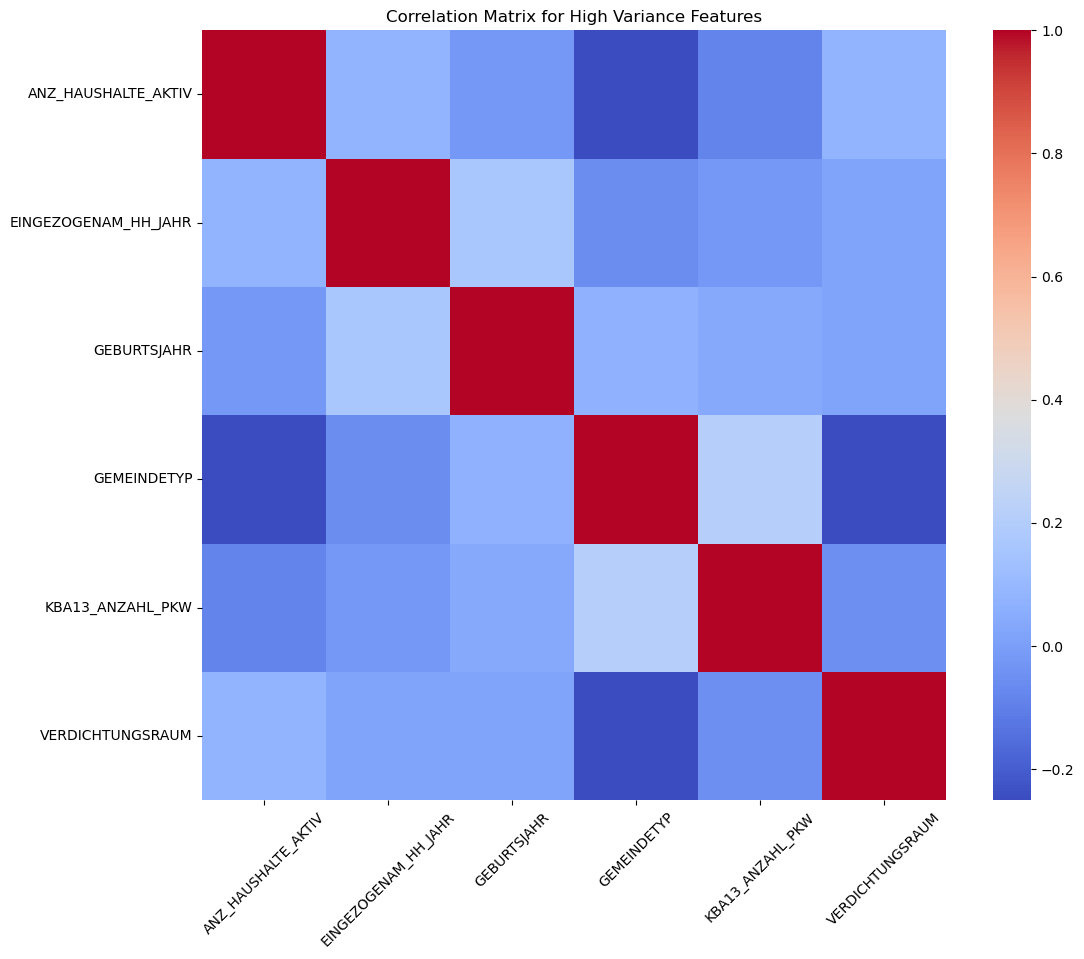

In [222]:
# Compute the simplified correlation matrix
corr_mat_azdias = df_azdias[high_var_cols_azdias].corr()

# Generate a heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_mat_azdias, annot=False, cmap='coolwarm', fmt=".2f")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
plt.title('Correlation Matrix for High Variance Features')
plt.show()

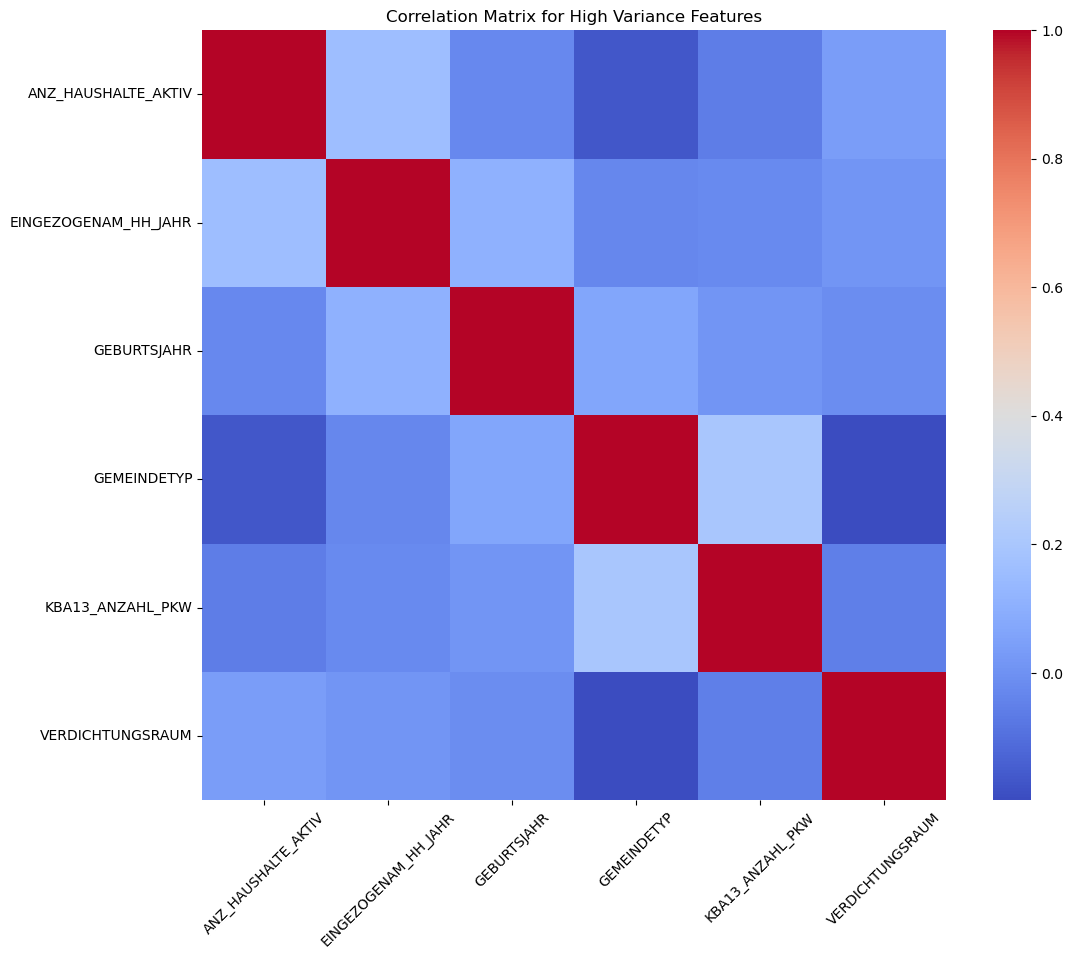

In [223]:
# Compute the simplified correlation matrix
corr_mat_customers = df_customers[high_var_cols_customers].corr()

# Generate a heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_mat_customers, annot=False, cmap='coolwarm', fmt=".2f")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
plt.title('Correlation Matrix for High Variance Features')
plt.show()

Comments: 

- Most of these highly volatile columns are weakly correlated with each others. 

Scale features to the same range prior to applying PCA

In [224]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned))
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_cleaned))

Use PCA to reduce dimensionality

Explained variance by 176 principal components: 0.90
Shape of PCA transformed data: (891221, 176)


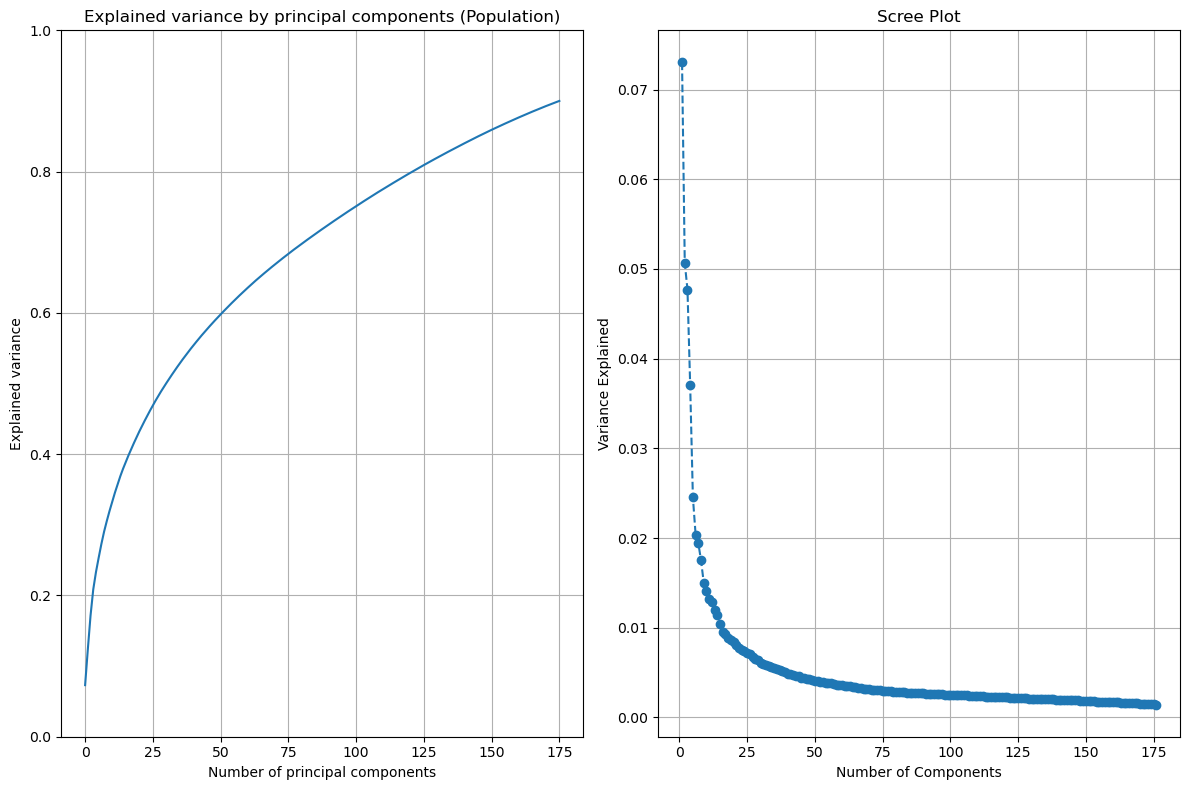

In [225]:
from sklearn.decomposition import PCA

# Initialise PCA with 0.9 variance to be retained
pca = PCA(n_components=0.9)
azdias_pca = pca.fit_transform(azdias_scaled)

# Explained variance
print(f"Explained variance by {pca.n_components_} principal components: {sum(pca.explained_variance_ratio_):.2f}")

# View the shape of the output data (should have reduced columns)
print("Shape of PCA transformed data:", azdias_pca.shape)

# Plots for cumulative explained variance and explained variance ratio
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

axes[0].plot(np.cumsum(pca.explained_variance_ratio_))
axes[0].set_title('Explained variance by principal components (Population)')
axes[0].set_xlabel('Number of principal components')
axes[0].set_ylabel('Explained variance')
axes[0].set_ylim(0, 1)
axes[0].grid(True)

axes[1].plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
axes[1].set_title('Scree Plot')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Variance Explained')
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Explained variance by 176 principal components: 0.90
Shape of PCA transformed data: (191652, 176)


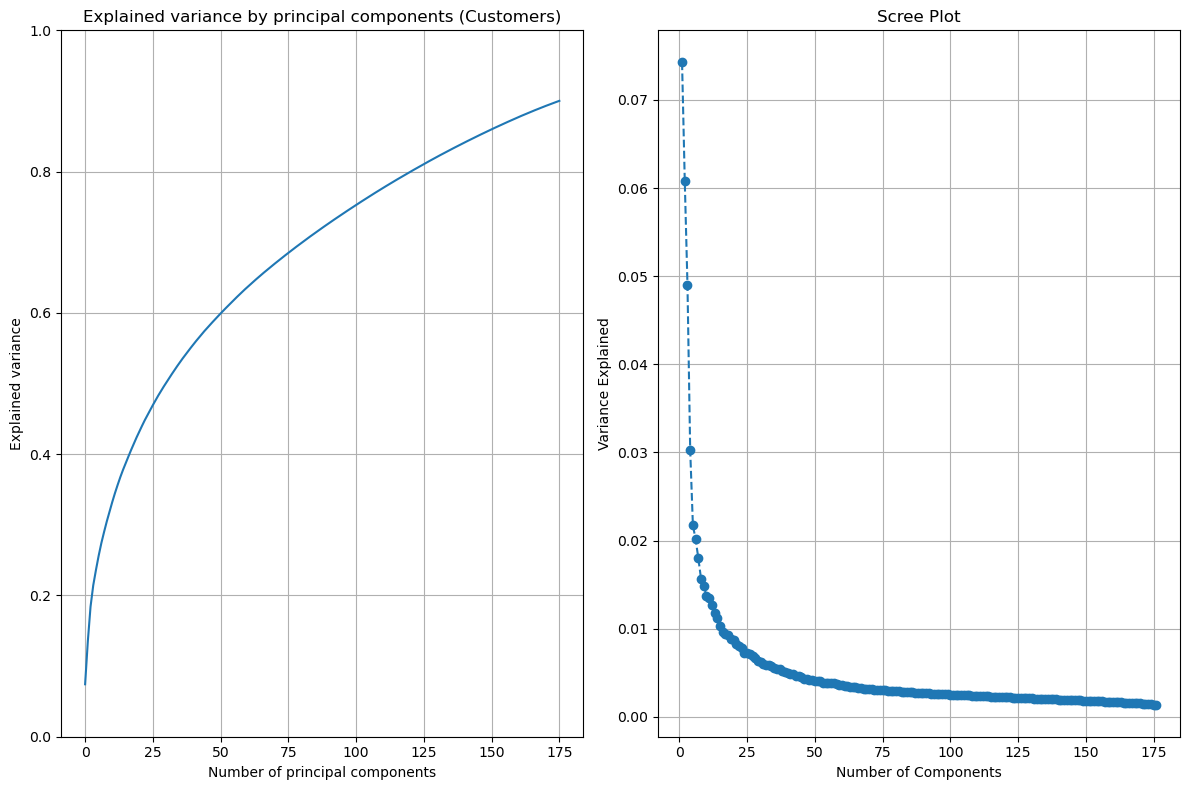

In [226]:
# Initialise PCA with 0.9 variance to be retained
pca = PCA(n_components=0.9)
customers_pca = pca.fit_transform(customers_scaled)

# Explained variance
print(f"Explained variance by {pca.n_components_} principal components: {sum(pca.explained_variance_ratio_):.2f}")

# View the shape of the output data (should have reduced columns)
print("Shape of PCA transformed data:", customers_pca.shape)

# Plots for cumulative explained variance and explained variance ratio
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

axes[0].plot(np.cumsum(pca.explained_variance_ratio_))
axes[0].set_title('Explained variance by principal components (Customers)')
axes[0].set_xlabel('Number of principal components')
axes[0].set_ylabel('Explained variance')
axes[0].set_ylim(0, 1)
axes[0].grid(True)

axes[1].plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
axes[1].set_title('Scree Plot')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Variance Explained')
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### 1.3 Model Building and Evaluation

In this modelling section, we experiment with two methods with two datasets — directly selecting top 10 features from **azdias_scaled** and using **principal_components** derived from PCA. Then we evaluate which one provides better performance for customer segmentation. 

In [227]:
from sklearn.cluster import KMeans

def plot_kmeans(data, min_clusters, max_clusters):
    """
    Apply KMeans clustering and plot the number of clusters against 
    the average within-cluster distance (or inertia). 

    Parameters:
    - data (np.array or DataFrame): The dataset to cluster.
    - min_clusters (int): The minimum number of clusters to test.
    - max_clusters (int): The maximum number of clusters to test.

    Returns:
    - A plot of number of clusters vs inertia.
    """
    # Range of cluster sizes to evaluate
    cluster_range = range(min_clusters, max_clusters + 1)

    # List to hold the inertias for each cluster size
    inertias = []

    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, inertias, marker='o', linestyle='-', color='b')
    plt.title('K-Means Plot')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.grid(True)
    plt.show()

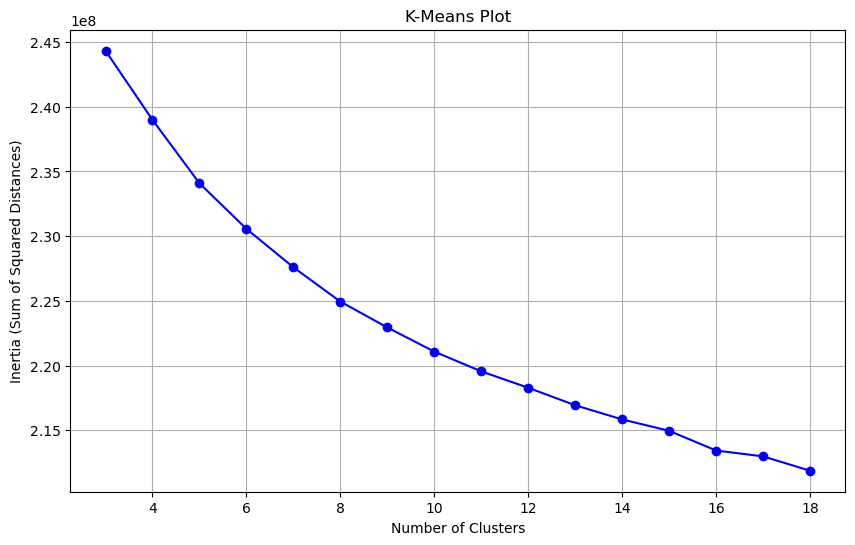

In [229]:
plot_kmeans(azdias_pca, 3, 18)

Comments: 

- It's evident that within-cluster distances decrease significantly until the number of clusters approaches 16. Thereofre, we choose 16 clusters to be the optimal number of clusters for the population data.

In [230]:
def fit_kmeans(data, n_clusters=16):
    
    # Fit the K-Means model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    
    # Predict the cluster labels
    labels = kmeans.predict(data)
    
    return kmeans, labels

In [231]:
# Apply to the azdias PCA data
azdias_kmeans, azdias_labels = fit_kmeans(azdias_pca)

# Apply to the customers PCA data
customers_kmeans, customers_labels = fit_kmeans(customers_pca)

In [232]:
display(azdias_labels)
display(customers_labels)


array([ 1,  5,  5, ...,  3,  2, 13], dtype=int32)

array([ 5,  7,  6, ...,  7,  6, 10], dtype=int32)

In [233]:
cluster_info = pd.DataFrame([])

cluster_info["Population"] = pd.Series(azdias_labels).value_counts().sort_index()
cluster_info["Customer"] = pd.Series(customers_labels).value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

cluster_info

,Cluster,Population,Customer
0,0,67121,5368
1,1,79186,8003
2,2,66573,46930
3,3,77444,7815
4,4,787,257
5,5,92318,18887
6,6,45140,13373
7,7,73930,18417
8,8,35683,2836
9,9,46674,198


In [234]:
cluster_info = pd.DataFrame([])

# Create a table to display the counts and relative proportions for both Population and Customer clusters
cluster_info["Population"] = pd.Series(azdias_labels).value_counts().sort_index()
cluster_info['Population %'] = (cluster_info['Population'] / cluster_info['Population'].sum()) * 100
cluster_info["Customer"] = pd.Series(customers_labels).value_counts().sort_index()
cluster_info['Customer %'] = (cluster_info['Customer'] / cluster_info['Customer'].sum()) * 100
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

cluster_info


,Cluster,Population,Population %,Customer,Customer %
0,0,67121,7.531353,5368,2.800910
1,1,79186,8.885114,8003,4.175798
2,2,66573,7.469864,46930,24.487091
3,3,77444,8.689652,7815,4.077703
4,4,787,0.088306,257,0.134097
5,5,92318,10.358598,18887,9.854841
6,6,45140,5.064961,13373,6.977751
7,7,73930,8.295361,18417,9.609605
8,8,35683,4.003833,2836,1.479765
9,9,46674,5.237085,198,0.103312


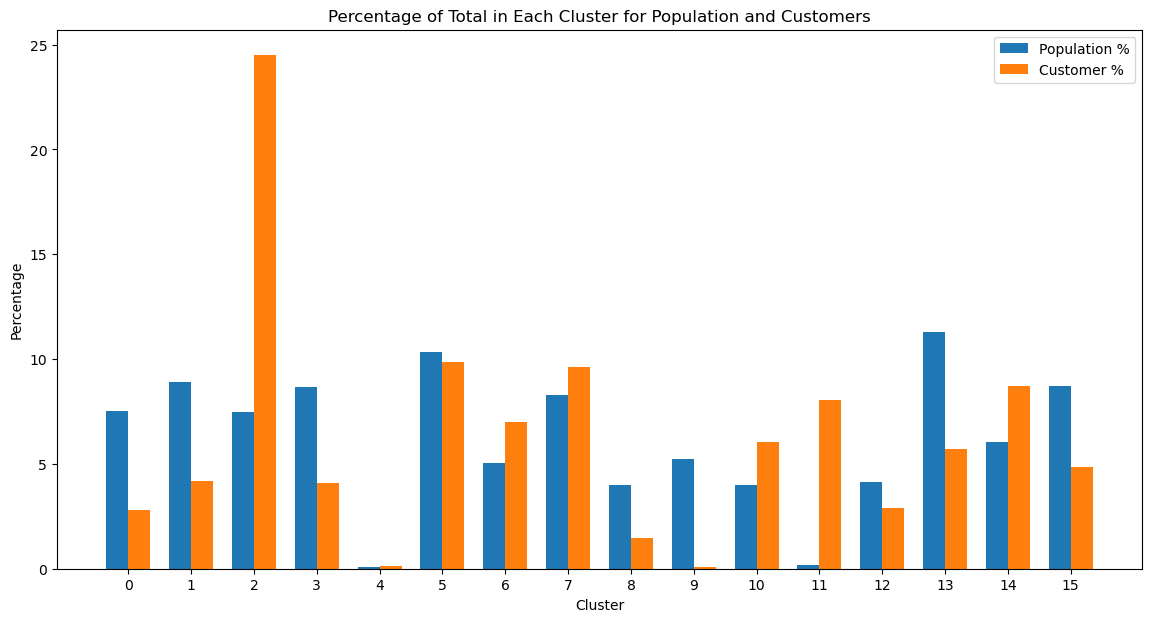

In [235]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 7))

# Positions for the bars on the x-axis
x = cluster_info.index

# Width of the bars
width = 0.35

# Plot data
plt.bar(x - width/2, cluster_info['Population %'], width, label='Population %')
plt.bar(x + width/2, cluster_info['Customer %'], width, label='Customer %')

# Adding labels and title
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Percentage of Total in Each Cluster for Population and Customers')
plt.xticks(ticks=x, labels=cluster_info['Cluster'])  # Set x-tick labels
plt.legend()

plt.show()

In [236]:
# Calculate the relative proportion for each cluster
cluster_info['Relative Proportion'] = (
    cluster_info['Customer %'] / (cluster_info['Customer %'] + cluster_info['Population %'])
)

# Sort the DataFrame by the relative proportion in descending order
display(cluster_info.sort_values(by='Relative Proportion', ascending=False))


,Cluster,Population,Population %,Customer,Customer %,Relative Proportion
11,11,1642,0.184242,15408,8.039572,0.977597
2,2,66573,7.469864,46930,24.487091,0.766252
4,4,787,0.088306,257,0.134097,0.602947
10,10,35565,3.990593,11566,6.034897,0.601955
14,14,53861,6.043507,16735,8.731973,0.590977
6,6,45140,5.064961,13373,6.977751,0.579417
7,7,73930,8.295361,18417,9.609605,0.536701
5,5,92318,10.358598,18887,9.854841,0.487539
12,12,37037,4.155759,5536,2.888569,0.410056
15,15,77769,8.726118,9339,4.872895,0.358327


### 1.4 Project Review and Conclusion 

The clustering analysis implemented in this project has effectively segmented the general population and the customer base of the mail-order company into 16 distinct clusters. By comparing the distribution of the company's existing customers across these clusters against their representation in the general population, we have the following insights:

- Clusters 11, and 2 exhibit notably higher proportions of customers relative to their presence in the general population, suggesting that individuals in these clusters are much more likely to be part of the mail-company's customer base. 

- Cluster 9, 8 and 0 show significantly lower proportions of customers compared to their sizes in the general population. Especially Cluster 9, observations in this cluster are almost unlikely to be in the company's customer base. suggesting that this group is the least likely to be part of the mail-order company's customer base. 

Therefore, identifying segments in this way possibly suggest where marketing efforts might be more or less effective, or where there could be opportunities for market penetration.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
# # Load in the data (RUN THIS CELL ON JUPYTER NOTEBOOK)
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [237]:
# Load in the data (RUN THIS CELL ON LOCAL VSCODE DESKTOP)
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/var/folders/p2/k2r08vgd17bc1xcc1zkn7_c40000gn/T/ipykernel_4326/7034250.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
/var/folders/p2/k2r08vgd17bc1xcc1zkn7_c40000gn/T/ipykernel_4326/7034250.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [238]:
print(mailout_train.shape)
display(mailout_train.head())

(42962, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [239]:
print(mailout_test.shape)
display(mailout_test.head())

(42833, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


### 2.1 Data Pre-processing

- Data cleaning

- Feature Engineering

-  Data Scaling

- Dimensionality Reduction (PCA)

In [240]:
# Clean the dataset
df_mailout_train = data_cleaning(mailout_train)

In [241]:
from sklearn.utils import resample

# Handle imbalance 
print(df_mailout_train.RESPONSE.value_counts())

response_1 = df_mailout_train[df_mailout_train.RESPONSE == 1] 
response_0 = df_mailout_train[df_mailout_train.RESPONSE == 0]
count_class_0 = df_mailout_train.RESPONSE.value_counts()[0]
response_1_balanced = resample(response_1, replace=True, n_samples=count_class_0, random_state=1)
df_mailout_train = pd.concat([response_0, response_1_balanced])

print(df_mailout_train.RESPONSE.value_counts())


0    42430
1      532
Name: RESPONSE, dtype: int64
0    42430
1    42430
Name: RESPONSE, dtype: int64


In [242]:
# Feature selection
X = df_mailout_train.drop('RESPONSE', axis=1)
y = df_mailout_train['RESPONSE']

In [243]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [244]:
# Apply PCA
pca = PCA(n_components=0.9) 
X_pca = pca.fit_transform(X_scaled)

print("Number of PCA components kept:", pca.n_components_)

Number of PCA components kept: 166


### 2.2 Exploratory Data Analysis (EDA)

- Visualisations

- Correlation Analysis

In [245]:
print(mailout_train.RESPONSE.value_counts())

0    42430
1      532
Name: RESPONSE, dtype: int64


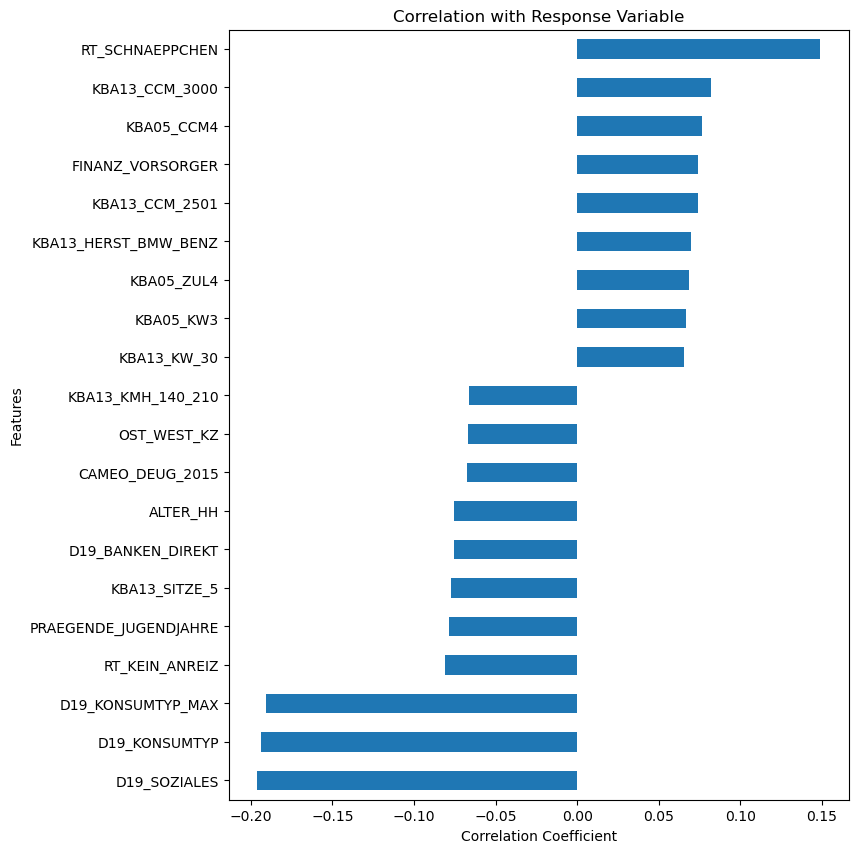

In [246]:
# Correlation of all features with the response variable
response_correlation = df_mailout_train.corr()['RESPONSE'].sort_values()

# Selecting top and bottom N features
N = 10  # You can adjust N based on your preference or readability
top_features = response_correlation.head(N+1)  # Least correlated (negative)
bottom_features = response_correlation.tail(N)  # Most correlated (positive)

# Combine top and bottom features, excluding the 'RESPONSE' self-correlation
important_features = pd.concat([top_features, bottom_features]).drop('RESPONSE')

# Plot
plt.figure(figsize=(8, 10))
important_features.plot(kind='barh')
plt.title('Correlation with Response Variable')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

Comment: 

- The correlations of all features with the RESPONSE variable are between -0.20 and 0.15, which may suggest weak linear or non-linear relationships. Therefore, apart from basic model, we could try more models that can handle non-linear relationships, such as logistic regression, random forests, or neural networks. 

### 2.3 Model Selection

- Baseline Model: Logistic Regression

- Complex Models: Experiment with more complex models like Random Forest, Gradient Boosting Machines (GBM), and neural networks if computational resources allow. 

- Choice of Recall as the Evaluation Metric: We use recall as the main metric because in our mail campaign, the cost of missing potential customers (predicting non-response when there is a response) outweighs the cost of false positive. Given the imbalanced nature of the dataset with fewer responses, recall ensures that our model maximally identifies actual responders, while minimising the risk of losing potential customers.

In [247]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [248]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def train_classifier(classifier, param_grid, X = X_train, y = y_train):
    """
    Fit a classifier using GridSearchCV, compute ROC AUC metric.
    
    INPUT:
    - classifier (classifier): The classifier to fit.
    - param_grid (dict): Dictionary with parameters names (str) as keys and lists of parameter settings to try as values.
    - X (DataFrame): Features of the training dataframe.
    - y (DataFrame): Labels of the training dataframe.
            
    OUTPUT:
    - classifier: Fitted classifier.
    - Prints AUROC score and elapsed time.
    """
    
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)
    grid.fit(X, y)
    
    print('ROC-AUC Score:', grid.best_score_)
    
    return grid.best_estimator_

#### 1. Baseline Model: Logistic Regression

In [249]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

# Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_val)
recall_lr = recall_score(y_val, y_pred_lr)

print(f'Logistic Regression Recall Score: {recall_lr}')

Logistic Regression Recall Score: 0.7566580249823238


/Users/kobe/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 2. Alternative Models: Random Forest 

In [250]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_val)
recall_rf = recall_score(y_val, y_pred_rf)

print(f'Random Forest Recall Score: {recall_rf}')

Random Forest Recall Score: 0.9111477728022626


#### 3. Alternative Models: Gradient Boosting Machine (GBM)

In [251]:
from sklearn.ensemble import GradientBoostingClassifier

# GBM model
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)

y_pred_gbm = gbm_model.predict(X_val)
recall_gbm = recall_score(y_val, y_pred_gbm)

print(f'Gradient Boosting Machine Recall Score: {recall_gbm}')

Gradient Boosting Machine Recall Score: 0.797784586377563


Summary: 

- Logistic Regression provided a baseline recall score of 75.67%. 

- More complex models delivered better results: Random Forest achieved the highest recall at 91.11%, and Gradient Boosting Machine showed a competitive 79.78%. 

- This indicates that ensemble methods, particularly Random Forest, are more effective at identifying true positives in this dataset, suggesting their suitability for further Hyperparameter Tuning and use in predicting campaign response. 

- We are able to observe a substantial improvement in recall with the Random Forest model. Without evidence of extreme overfitting (recall not excessively close to 100%), it's reasonable to adopt this model for further refinement and actual deployment. 

### 2.4 Model Training and Validation

- Hyperparameter Tuning: Use grid search or randomised search to find the optimal parameters for your chosen models.

- Model Evaluation: Use metrics such as ROC-AUC, recall and confusion matrix to evaluate model performance. 

In [252]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

def tune_and_evaluate_model(X_train, y_train, X_val, y_val, model, param_grid, cv=5):
    """
    Function to perform hyperparameter tuning and evaluation using cross-validation.
    
    Parameters:
    - X_train, y_train: training data and labels
    - X_val, y_val: validation data and labels
    - model: a sklearn model
    - param_grid: dictionary with parameters names (str) as keys and lists of parameter settings to try as values
    - cv: number of folds in cross-validation
    
    Returns:
    - Best model trained on the entire training set
    - Recall score on the validation set
    """
    # Setup the grid search with cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='recall', verbose=1)
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_ # Best model
    y_pred = best_model.predict(X_val) # Predict on validation set
    recall = recall_score(y_val, y_pred) # Calculate recall
    best_params = grid_search.best_params_ # Best parameter combination
    
    return best_model, recall, best_params

In [253]:
# Define the parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [10, 20, 40], 
    'max_features': ['auto', 'log2'], 
    'min_samples_split': [2, 10]
}

# Calling the function with the dataset
best_rf_model, recall_rf, best_params_rf = tune_and_evaluate_model(X_train, y_train, X_val, y_val, model = rf_model, param_grid = param_grid_rf, cv=5)

print(f'Optimized Random Forest Recall Score: {recall_rf}')
print(f'Best Parameter Combination: {best_params_rf}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Optimized Random Forest Recall Score: 0.9111477728022626
Best Parameter Combination: {'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 50}


In [254]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Using the best model to predict on validation set
y_pred = best_rf_model.predict(X_val)
y_pred_proba = best_rf_model.predict_proba(X_val)[:, 1]  # probabilities for AUC

# Calculate the common evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_proba)
conf_mat = confusion_matrix(y_val, y_pred)

# Print all metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {auc}')
print("Confusion Matrix:")
print(conf_mat)


Accuracy: 0.9412561866603818
Precision: 0.9695297805642633
Recall: 0.9111477728022626
F1 Score: 0.93943259826256
ROC AUC Score: 0.991823634985385
Confusion Matrix:
[[8243  243]
 [ 754 7732]]


In [255]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'cm' is not defined

<Figure size 800x600 with 0 Axes>

Comments: 

- The Random Forest model was fine-tuned and validated, achieving a high recall score of 91.11%. There is no much improvement in recall score compared with prior model. 

- The optimised model also demonstrated strong overall performance with a ROC AUC score of 99.18%, indicating excellent discriminative ability between the classes, or possibly over-fitting. 

- The confusion matrix highlights the model’s effectiveness, with a substantial number of true positives and true negative and a acceptable number of false predictions, supporting its reliability and precision in predicting responses.

### 2.5 Predictions on Test Data

- Apply Preprocessing: Ensure that the same preprocessing steps are also applied to the test data. 

- Make Predictions: Use the trained model to make predictions on the test data.


In [ ]:
df_mailout_test = data_cleaning(mailout_test)
X_test = df_mailout_test.copy()

X_test_scaled = scaler.fit_transform(X_test) # Scale features

In [ ]:
# Use the best model to make predictions
y_test_pred = best_rf_model.predict(X_test_scaled)
y_test_pred_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Optionally, print or return predictions
print("Predictions on Test Data:", y_test_pred)

Predictions on Test Data: [0 0 0 ... 0 0 0]


In [ ]:
print(pd.Series(y_test_pred).value_counts())

0    41798
1     1035
dtype: int64


Comments: 

- The same preprocessing steps used for the training data were applied to the test dataset, ensuring consistency in feature handling and scaling. The optimised RandomForest model was then employed to predict responses on the test data. 

- The results indicate that the model predicted a relatively small proportion of responses (1035 out of 42833). Such a distribution suggests that the model is cautious in classifying individuals as responders. 

### 2.8 Documentation and Reporting

- Document the Process: Clearly document all steps, decisions, and justifications in your approach, including preprocessing decisions, model choice, and key observations from model evaluations.

- Project Summary: Summarize the findings, including insights on data characteristics, model performance, and potential business impacts of the predictive model.

- Future Work: Suggest possible improvements or additional analyses that could enhance the model or provide more insights into customer behavior.